## Declare required dependencies

In [1]:
import pandas as pd
import numpy as np
import pickle

from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader


import torch.utils.data as data_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["0", "1"]

## Data ingestion

National Health and Nutrition Health Survey 2013-2014 (NHANES) Age Prediction Subset

https://archive.ics.uci.edu/dataset/887/national+health+and+nutrition+health+survey+2013-2014+(nhanes)+age+prediction+subset

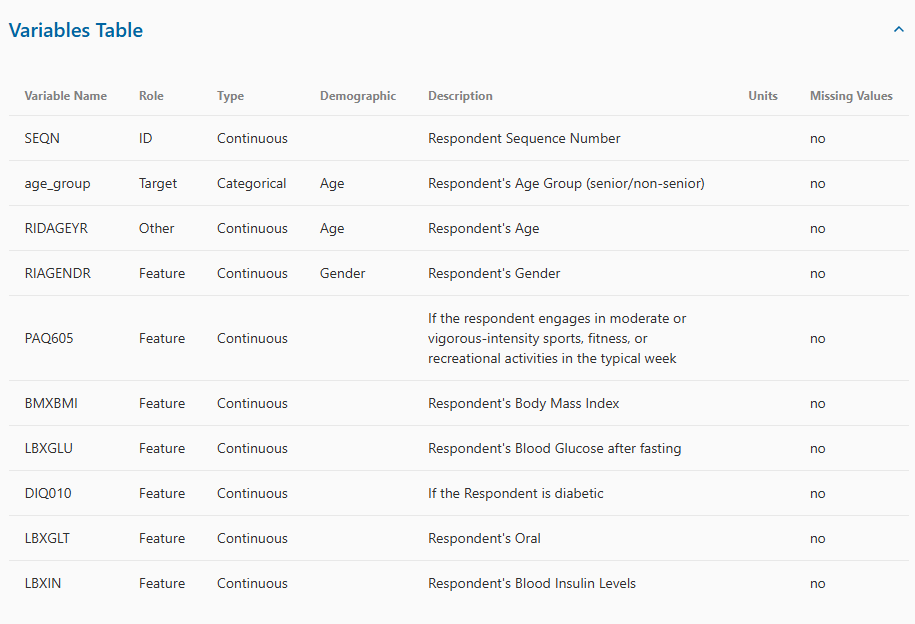

Описание данных:

Целевая переменная:
* age_group - возрастная группа (пожилой, не пожилой).

Признаки:
*   RIAGENDR - пол;
*   BMXBMI - индекс массы тела;
*   LBXGLU - уровень глюкозы в крови после голодания;
*   DIQ010 - если респондент страдает диабетом;
*   LBXGLT - устные ответы респондента;
*   LBXIN - уровень инсулина в крови.





In [2]:
!pip install ucimlrepo

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_palette('husl')
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from ucimlrepo import fetch_ucirepo

In [4]:
data_train = fetch_ucirepo(id=887) #айди датасета с сайта

X = data_train.data.features
y = data_train.data.targets

vals = ["Adult","Senior"]
y = y.replace(vals, [0, 1])

cols = ['RIAGENDR', 'BMXBMI', 'LBXGLU', 'DIQ010', 'LBXGLT', 'LBXIN', 'age_group']
d = pd.concat([X, y], axis=1)
df = d[cols]

<ipython-input-4-b95b7f8753ca>:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = y.replace(vals, [0, 1])


## Data exploration

In [5]:
df.head(5)

,RIAGENDR,BMXBMI,LBXGLU,DIQ010,LBXGLT,LBXIN,age_group
0,2.0,35.7,110.0,2.0,150.0,14.91,0
1,2.0,20.3,89.0,2.0,80.0,3.85,0
2,1.0,23.2,89.0,2.0,68.0,6.14,0
3,1.0,28.9,104.0,2.0,84.0,16.15,0
4,2.0,35.9,103.0,2.0,81.0,10.92,0


In [6]:
print(df.shape)
print(df.describe())

(2278, 7)
          RIAGENDR       BMXBMI       LBXGLU       DIQ010       LBXGLT  \
count  2278.000000  2278.000000  2278.000000  2278.000000  2278.000000   
mean      1.511414    27.955180    99.553117     2.016242   114.978929   
std       0.499979     7.248962    17.889834     0.185556    47.061239   
min       1.000000    14.500000    63.000000     1.000000    40.000000   
25%       1.000000    22.800000    91.000000     2.000000    87.000000   
50%       2.000000    26.800000    97.000000     2.000000   105.000000   
75%       2.000000    31.200000   104.000000     2.000000   130.000000   
max       2.000000    70.100000   405.000000     3.000000   604.000000   

             LBXIN    age_group  
count  2278.000000  2278.000000  
mean     11.834794     0.159789  
std       9.718812     0.366491  
min       0.140000     0.000000  
25%       5.860000     0.000000  
50%       9.040000     0.000000  
75%      14.440000     0.000000  
max     102.290000     1.000000  


## Ести ли пропуски?

In [7]:
df.isnull().values.any()

False

## Class distribution ( 0 - Adult, 1 - Senior)

In [8]:
df['age_group'].value_counts()

,count
age_group,
0,1914
1,364


<ipython-input-9-2c1c28c24203>:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(df['age_group'], sort = True)


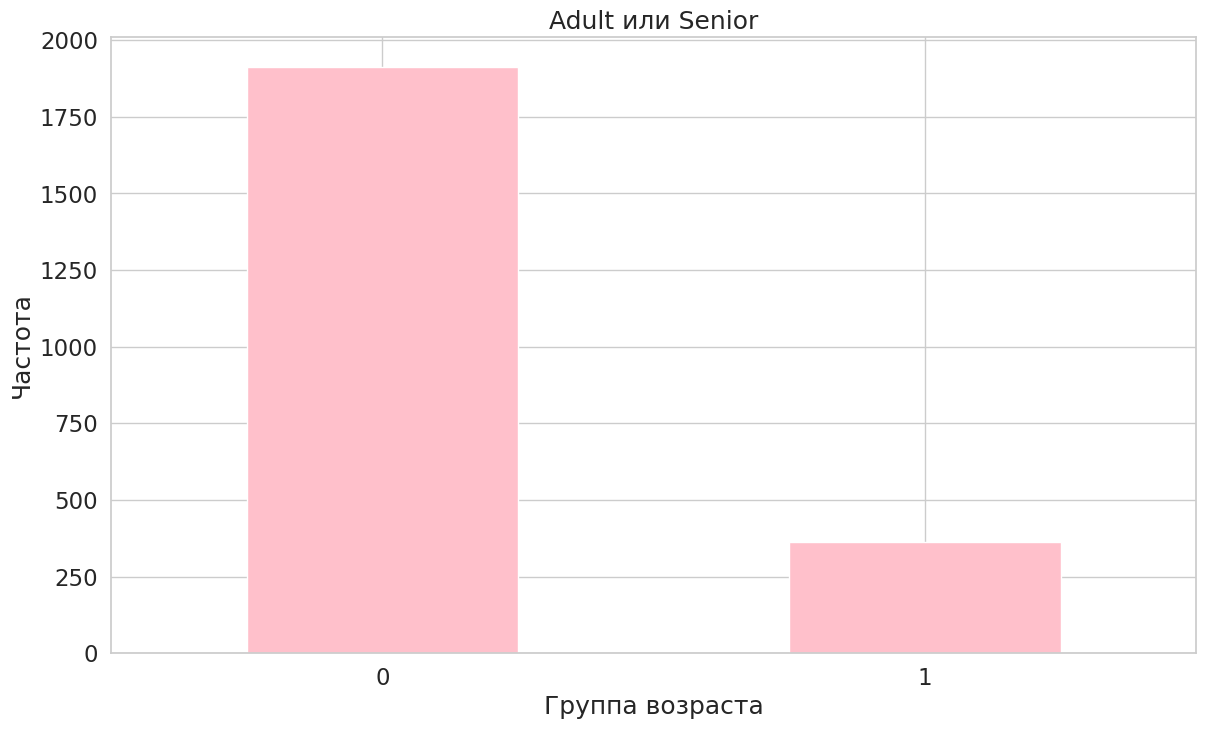

In [9]:
count_classes = pd.value_counts(df['age_group'], sort = True)
count_classes.plot(kind = 'bar', rot=0, color="pink")
plt.title("Adult или Senior")
plt.xticks(range(2), LABELS)
plt.xlabel("Группа возраста")
plt.ylabel("Частота");

Наш набор данных очень сильно несбалансирован в пользу 2 класса. Это требует дальнейшего изучения данных

In [10]:
seniorDF = df[df.age_group == 1]
adultDF = df[df.age_group == 0]

In [11]:
seniorDF.shape

(364, 7)

In [12]:
adultDF.shape

(1914, 7)

Давайте теперь посмотрим на сумму денег, задействованную в двух классах.

In [13]:
seniorDF.describe()

,RIAGENDR,BMXBMI,LBXGLU,DIQ010,LBXGLT,LBXIN,age_group
count,364.000000,364.000000,364.00000,364.000000,364.000000,364.000000,364.0
mean,1.508242,27.886264,104.32967,2.027473,141.208791,10.405247,1.0
std,0.500620,5.574166,14.96667,0.266211,51.549440,7.530538,0.0
min,1.000000,16.800000,80.00000,1.000000,48.000000,1.020000,1.0
25%,1.000000,24.200000,95.00000,2.000000,104.000000,5.247500,1.0
50%,2.000000,27.200000,101.00000,2.000000,131.000000,8.465000,1.0
75%,2.000000,30.600000,111.00000,2.000000,166.250000,13.212500,1.0
max,2.000000,52.200000,208.00000,3.000000,346.000000,52.890000,1.0


In [14]:
adultDF.describe()

,RIAGENDR,BMXBMI,LBXGLU,DIQ010,LBXGLT,LBXIN,age_group
count,1914.000000,1914.000000,1914.000000,1914.000000,1914.000000,1914.000000,1914.0
mean,1.512017,27.968286,98.644723,2.014107,109.990596,12.106661,0.0
std,0.499986,7.526555,18.255726,0.165850,44.453655,10.060040,0.0
min,1.000000,14.500000,63.000000,1.000000,40.000000,0.140000,0.0
25%,1.000000,22.600000,91.000000,2.000000,84.000000,5.982500,0.0
50%,2.000000,26.750000,96.000000,2.000000,101.000000,9.200000,0.0
75%,2.000000,31.400000,103.000000,2.000000,124.000000,14.790000,0.0
max,2.000000,70.100000,405.000000,3.000000,604.000000,102.290000,0.0


Graphically speaking ...`

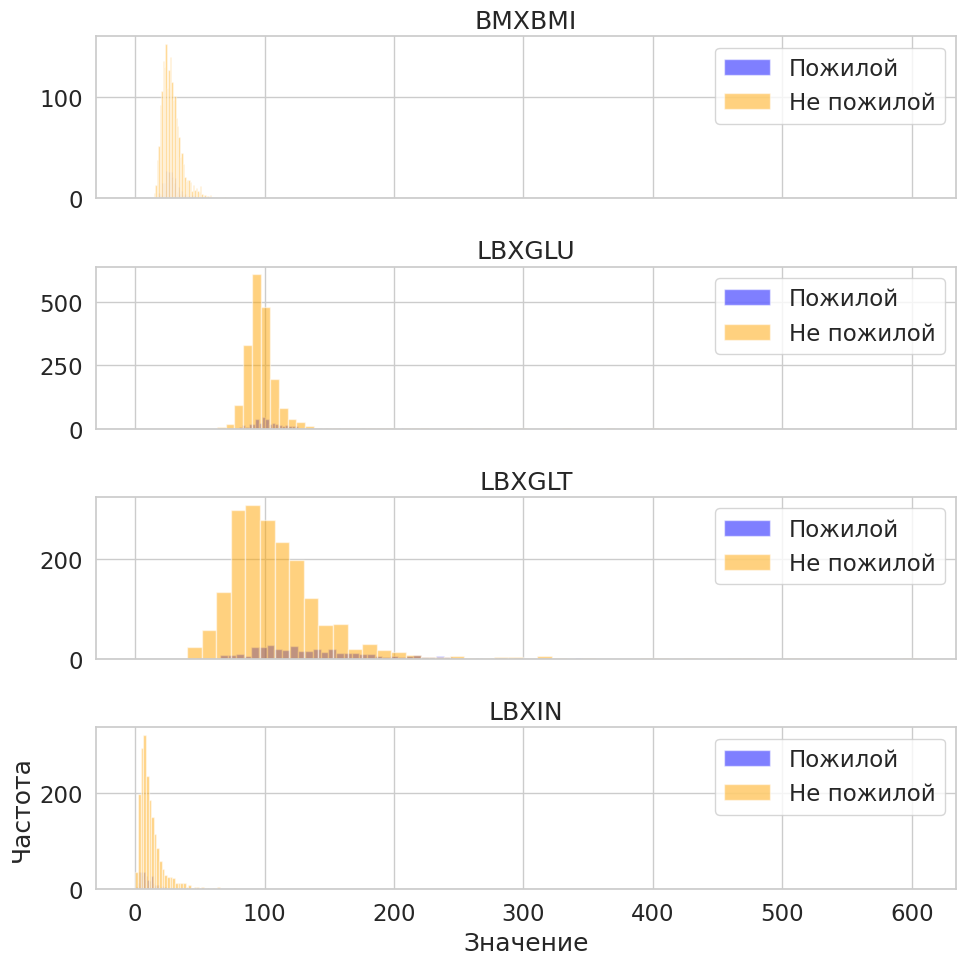

In [15]:
features = ['BMXBMI', 'LBXGLU', 'LBXGLT', 'LBXIN']
f, axs = plt.subplots(len(features), 1, figsize=(10, 10), sharex=True)

for i, feature in enumerate(features):
    bins = 50
    axs[i].hist(seniorDF[feature], bins=bins, alpha=0.5, label='Пожилой', color='blue')
    axs[i].hist(adultDF[feature], bins=bins, alpha=0.5, label='Не пожилой', color='orange')

    axs[i].set_title(feature)
    axs[i].legend()

plt.xlabel('Значение')
plt.ylabel('Частота')
plt.tight_layout()
plt.show()

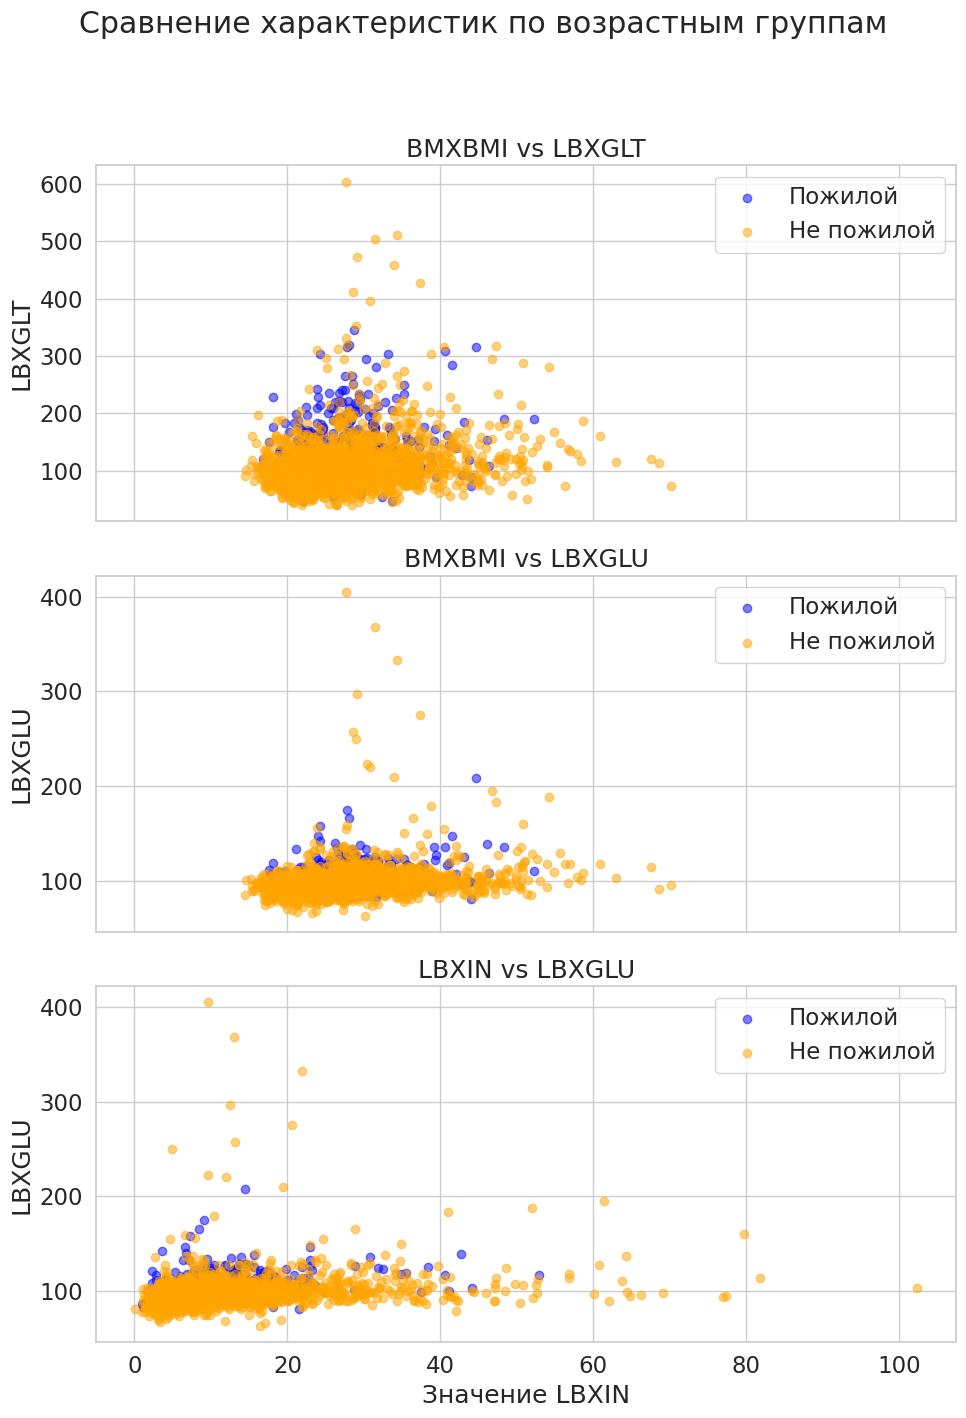

In [16]:
import matplotlib.pyplot as plt

# Определим пары для оси X и Y
features_pairs = [('BMXBMI', 'LBXGLT'), ('BMXBMI', 'LBXGLU'), ('LBXIN', 'LBXGLU')]

# Создаем фигуру и подграфики
f, axs = plt.subplots(len(features_pairs), 1, figsize=(10, 5 * len(features_pairs)), sharex=True)
f.suptitle('Сравнение характеристик по возрастным группам')

# Проходим по парам характеристик и строим графики
for i, (feature1, feature2) in enumerate(features_pairs):
    axs[i].scatter(seniorDF[feature1], seniorDF[feature2], alpha=0.5, color='blue', label='Пожилой')
    axs[i].scatter(adultDF[feature1], adultDF[feature2], alpha=0.5, color='orange', label='Не пожилой')

    axs[i].set_title(f'{feature1} vs {feature2}')
    axs[i].set_ylabel(feature2)
    axs[i].legend()

plt.xlabel('Значение ' + feature1)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Предоставляем место для общего заголовка
plt.show()


Похоже, что почти ничего не имеет значения для определения группы возраста. Вывод: болеют все одинаково, печально.

## Preprocessing

Стандартизируем данные

In [17]:
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])
df.head()

<ipython-input-17-4b2c37eb6fab>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[features] = scaler.fit_transform(df[features])


,RIAGENDR,BMXBMI,LBXGLU,DIQ010,LBXGLT,LBXIN,age_group
0,2.0,1.068639,0.584085,2.0,0.744323,0.316487,0
1,2.0,-1.056270,-0.590024,2.0,-0.743427,-0.821762,0
2,1.0,-0.656125,-0.590024,2.0,-0.998470,-0.586084,0
3,1.0,0.130367,0.248625,2.0,-0.658413,0.444103,0
4,2.0,1.096235,0.192715,2.0,-0.722174,-0.094147,0


In [18]:
df2 = df.copy()

### Разделите набор данных на наборы обучающих и тестовых данных.

Мы разделили набор данных как обучение = 80% и тест = 20%. В обучающем наборе данных будут только обычные транзакции, а в тестовом наборе данных будут как обычные, так и мошеннические транзакции.

In [19]:
X_train, X_test = train_test_split(df2, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.age_group == 0]
X_train = X_train.drop(['age_group'], axis=1)
#print(type(X_train))
y_test = X_test['age_group']
X_test = X_test.drop(['age_group'], axis=1)

X_train = X_train.values
#print(type(X_train))
X_test = X_test.values
y_test = y_test.values
print(y_test.size)


456


## Model
Мы построим автоэнкодер, состоящий из 4 полносвязных слоев с 14,7,7,29 нейронами. Первые 2 слоя действуют как кодировщик, а последние 2 слоя действуют как декодер. Обратите внимание, что последний слой имеет 29 узлов, соответствующих 29 функциям в элементе входных данных.

In [20]:
class Autoencoder(nn.Module):
    def __init__(self):  # Исправлено на __init__
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(6, 4),  # Изменено на 6 на входе
            nn.Tanh(),
            nn.Linear(4, 3),  # Уменьшаем размерность до 3
            nn.LeakyReLU(),
        )

        self.decoder = nn.Sequential(
            nn.Linear(3, 4),  # Увеличиваем до 4
            nn.Tanh(),
            nn.Linear(4, 6),  # Возвращаем на 6
            nn.LeakyReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [21]:
model = Autoencoder().double()
#model = Autoencoder().double().cpu()

In [22]:
num_epochs = 100   # сколько эпох будем обучать. Результаты обучения на одной эпохе используются как начальные для следующей.
minibatch_size = 32
learning_rate = 1e-3

**minibatch_size** - размер мини-пакета - это количество записей (или векторов), которые мы одновременно передаем в наш алгоритм обучения. Отношение между тем, насколько быстро наш алгоритм может обучить модель, обычно имеет U-образную форму (размер пакета в зависимости от скорости обучения). Это означает, что первоначально по мере увеличения размера партии время обучения будет уменьшаться. В конце концов  мы увидим, что время обучения начинает увеличиваться, когда мы превышаем определенный размер пакета, который слишком велик.
По мере увеличения размера мини-пакета большее количество вычислений означает, что градиенты могут быть более плавными, но их вычисление требует больших затрат. В идеале каждая мини-партия, на которой проводится обучение, должна содержать пример каждого класса, чтобы уменьшить ошибку выборки при оценке градиента для всей обучающей выборки.


**learning_rate** - скорость оптимизации (обучения). Насколько маленькими шашами мы изменяем градиент.

In [23]:
# Создание загрузчиков данных
train_loader = data_utils.DataLoader(X_train, batch_size=minibatch_size, shuffle=True)

In [24]:
#test = data_utils.TensorDataset(torch.from_numpy(X_test).double(),torch.from_numpy(y_test).double())
#test_loader = data_utils.DataLoader(test, batch_size=minibatch_size, shuffle=True)
test_loader = data_utils.DataLoader(X_test, batch_size=1, shuffle=False)

In [25]:
# Определение функции потерь и оптимизатора
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=10e-05)

In [26]:
# Словарь для хранения истории потерь
history = {}
history['train_loss'] = []
history['test_loss'] = []

- Проходит определенное количество эпох.
- На каждой эпохе проходит через весь обучающий набор данных с расчетом потерь.
- Производится обновление параметров модели с использованием методов обратного распространения.
- В конце сохраняются веса обученной модели для дальнейшего использования.

In [27]:
# Цикл обучения
for epoch in range(num_epochs):
    h = np.array([])
    for data in train_loader:
        #print(type(data))
        #data = Variable(data).cpu()
        #print(type(data))
        # ===================forward=====================
        output = model(data)
        loss = criterion(output, data)
        h = np.append(h, loss.item())

        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    mean_loss = np.mean(h)
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, mean_loss))
    history['train_loss'].append(mean_loss)

# Сохранение модели
torch.save(model.state_dict(), './agemodel.pth')

epoch [1/100], loss:1.8202
epoch [2/100], loss:1.7270
epoch [3/100], loss:1.6021
epoch [4/100], loss:1.5136
epoch [5/100], loss:1.4496
epoch [6/100], loss:1.3809
epoch [7/100], loss:1.0474
epoch [8/100], loss:0.8302
epoch [9/100], loss:0.7470
epoch [10/100], loss:0.7186
epoch [11/100], loss:0.7093
epoch [12/100], loss:0.7061
epoch [13/100], loss:0.7032
epoch [14/100], loss:0.6894
epoch [15/100], loss:0.6577
epoch [16/100], loss:0.6419
epoch [17/100], loss:0.6329
epoch [18/100], loss:0.6254
epoch [19/100], loss:0.6188
epoch [20/100], loss:0.6124
epoch [21/100], loss:0.6083
epoch [22/100], loss:0.6040
epoch [23/100], loss:0.6002
epoch [24/100], loss:0.5979
epoch [25/100], loss:0.5940
epoch [26/100], loss:0.5906
epoch [27/100], loss:0.5880
epoch [28/100], loss:0.5827
epoch [29/100], loss:0.5661
epoch [30/100], loss:0.5519
epoch [31/100], loss:0.5426
epoch [32/100], loss:0.5340
epoch [33/100], loss:0.5266
epoch [34/100], loss:0.5203
epoch [35/100], loss:0.5131
epoch [36/100], loss:0.5070
e

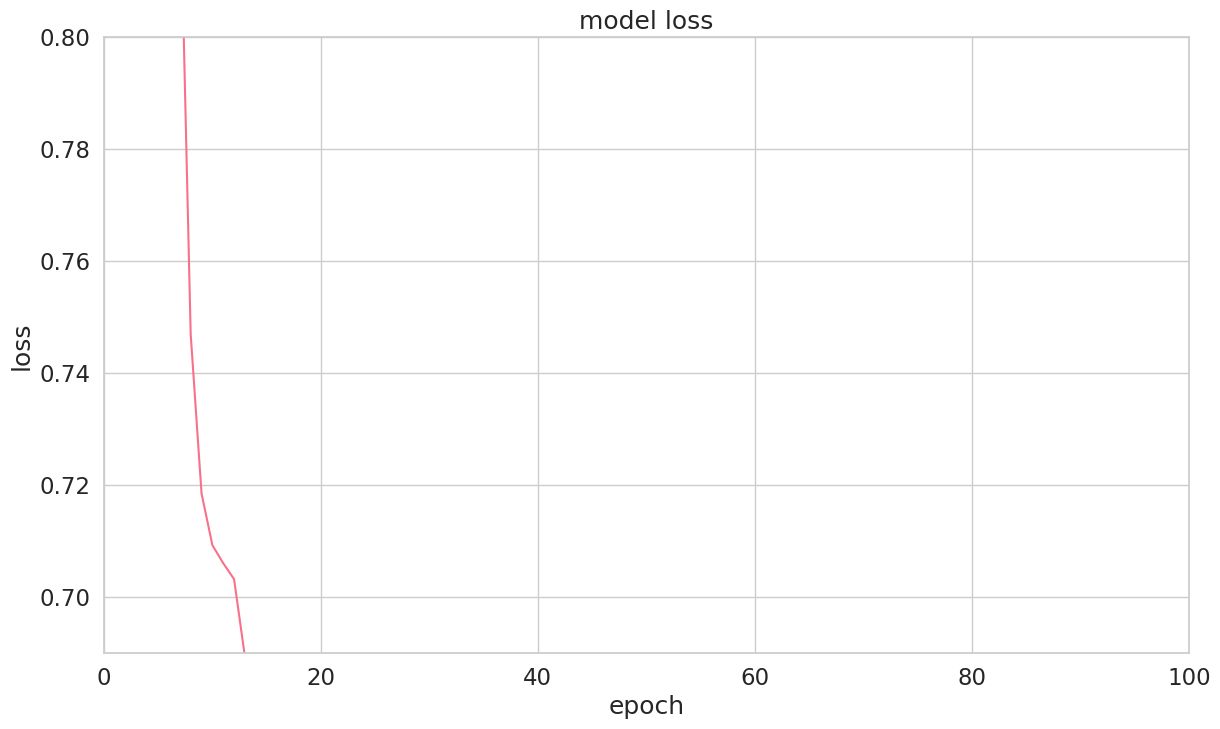

In [28]:
plt.plot(history['train_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.axis([0,100,0.69,0.80])

plt.show()

## Оценка модели

In [29]:
pred_losses = {'pred_loss' : []}
model.eval()
with torch.no_grad():
    for data in test_loader:
        inputs = data
        outputs = model(inputs)
        loss = criterion(outputs, inputs).data.item()
        pred_losses['pred_loss'].append(loss)
reconstructionErrorDF = pd.DataFrame(pred_losses)
reconstructionErrorDF['age_group'] = y_test

In [30]:
reconstructionErrorDF.describe()

,pred_loss,age_group
count,456.000000,456.000000
mean,0.340871,0.162281
std,1.177064,0.369113
min,0.003097,0.000000
25%,0.107338,0.000000
50%,0.211841,0.000000
75%,0.341805,0.000000
max,20.578664,1.000000


In [31]:
reconstructionErrorDF.describe()

,pred_loss,age_group
count,456.000000,456.000000
mean,0.340871,0.162281
std,1.177064,0.369113
min,0.003097,0.000000
25%,0.107338,0.000000
50%,0.211841,0.000000
75%,0.341805,0.000000
max,20.578664,1.000000


# Reconstruction Errors without Fraud

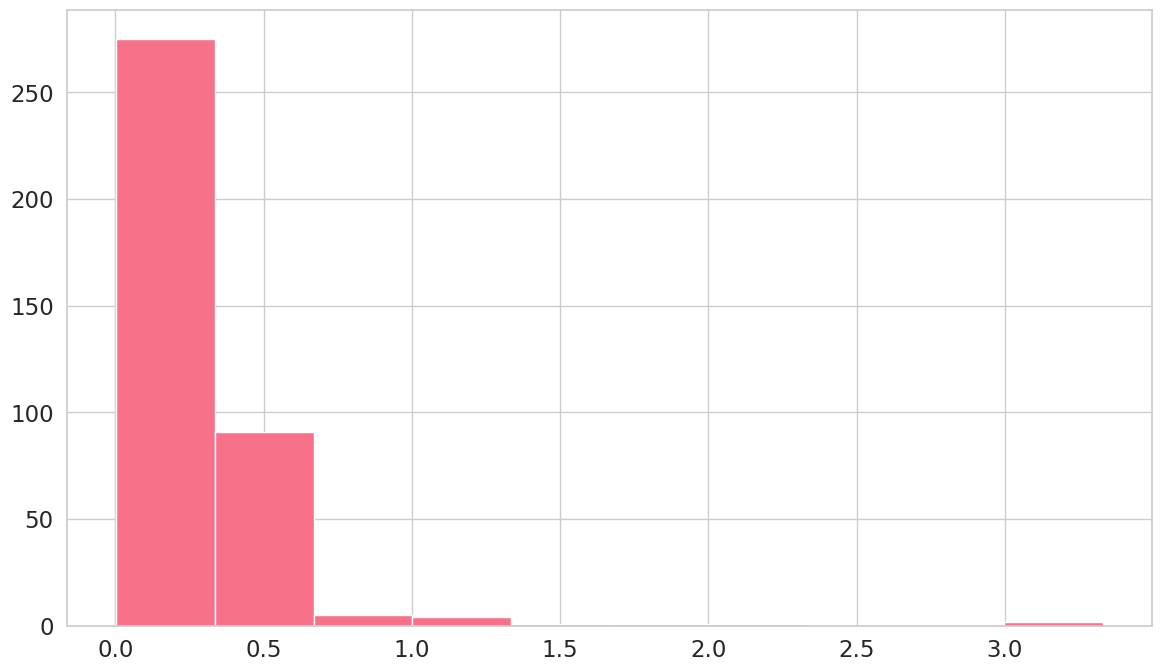

In [32]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = reconstructionErrorDF[(reconstructionErrorDF['age_group']== 0) & (reconstructionErrorDF['pred_loss'] < 10)]
_ = ax.hist(normal_error_df.pred_loss.values, bins=10)

# Reconstruction Errors with Fraud

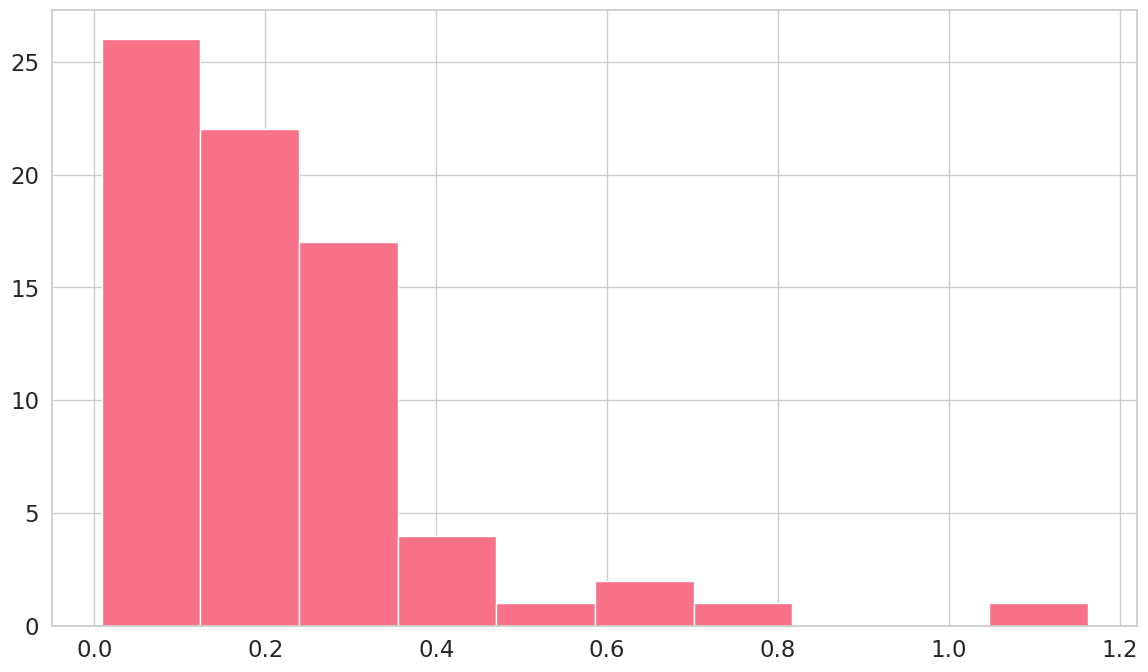

In [33]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = reconstructionErrorDF[(reconstructionErrorDF['age_group']== 1) ]
_ = ax.hist(fraud_error_df.pred_loss.values, bins=10)

## ROC Curves

ROC-кривая очень часто используется для анализа бинарных классификаторов. Он рассматривает все возможные пороговые значения для данного классификатора и показывает процент ложных срабатываний (FPR) по сравнению с показателями истинно положительных результатов (TPR).

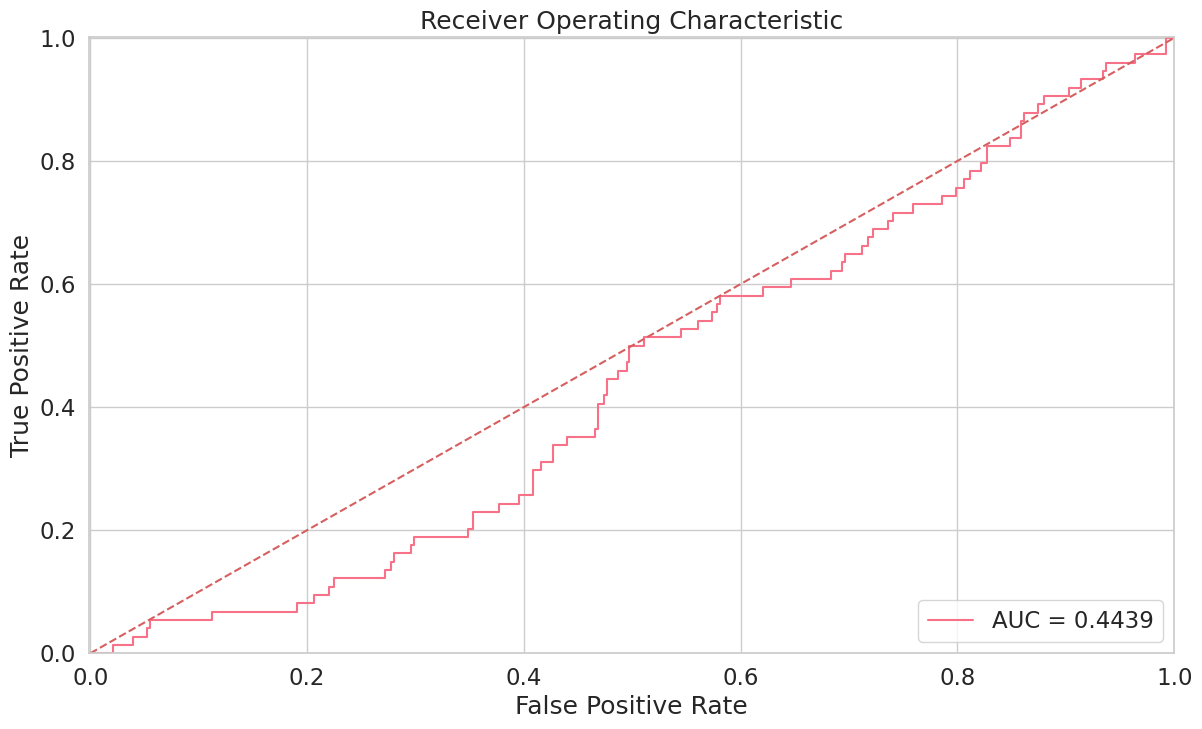

In [34]:
fpr, tpr, thresholds = roc_curve(reconstructionErrorDF.age_group, reconstructionErrorDF.pred_loss)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

## Precision vs Recall

Установка порога, который используется для принятия решения о классификации в модели, — это способ настроить компромисс между точностью (precision) и полнотой (recall) для данного классификатора.

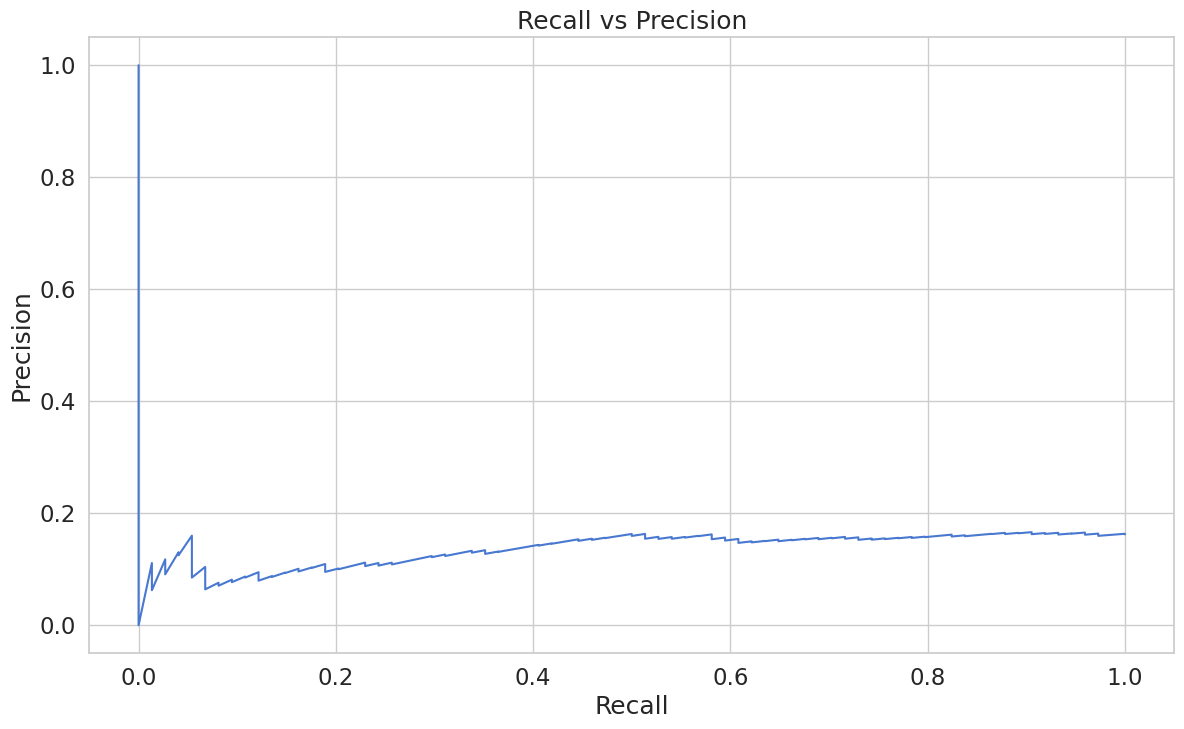

In [35]:
precision, recall, th = precision_recall_curve(reconstructionErrorDF.age_group, reconstructionErrorDF.pred_loss)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

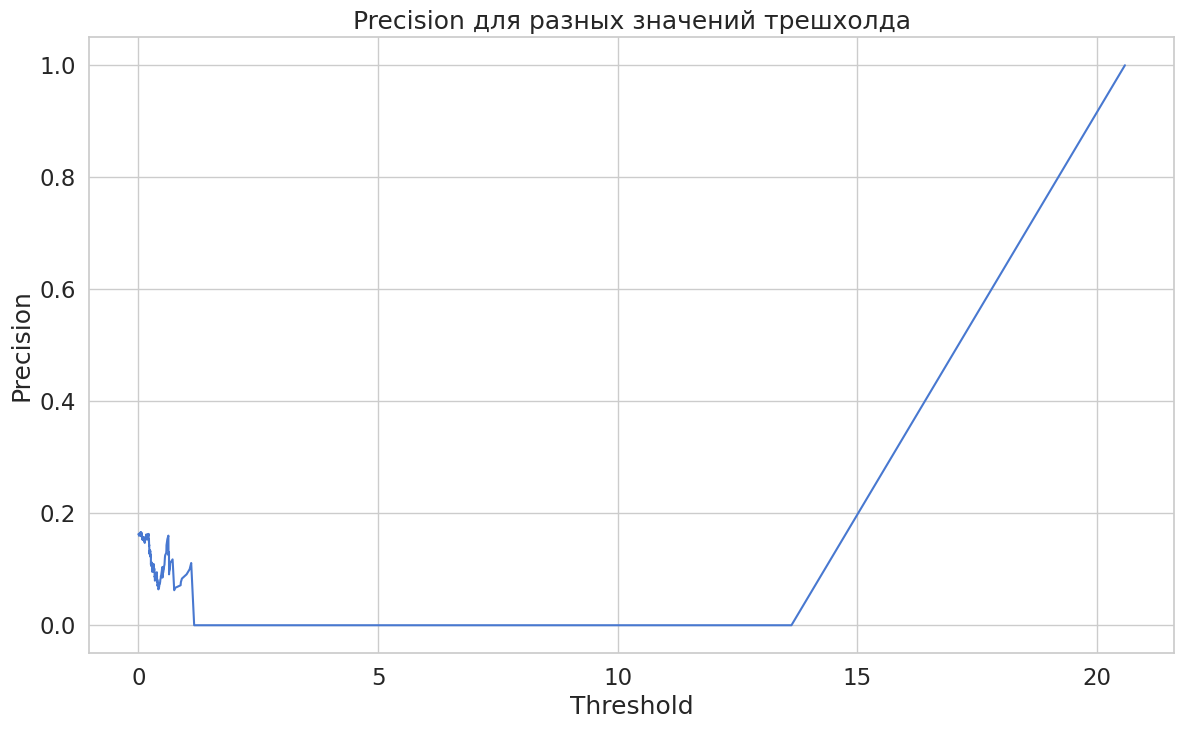

In [36]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision для разных значений трешхолда')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

Вы можете видеть, что по мере увеличения ошибки реконструкции повышается и наша precision. Давайте посмотрим на recall:


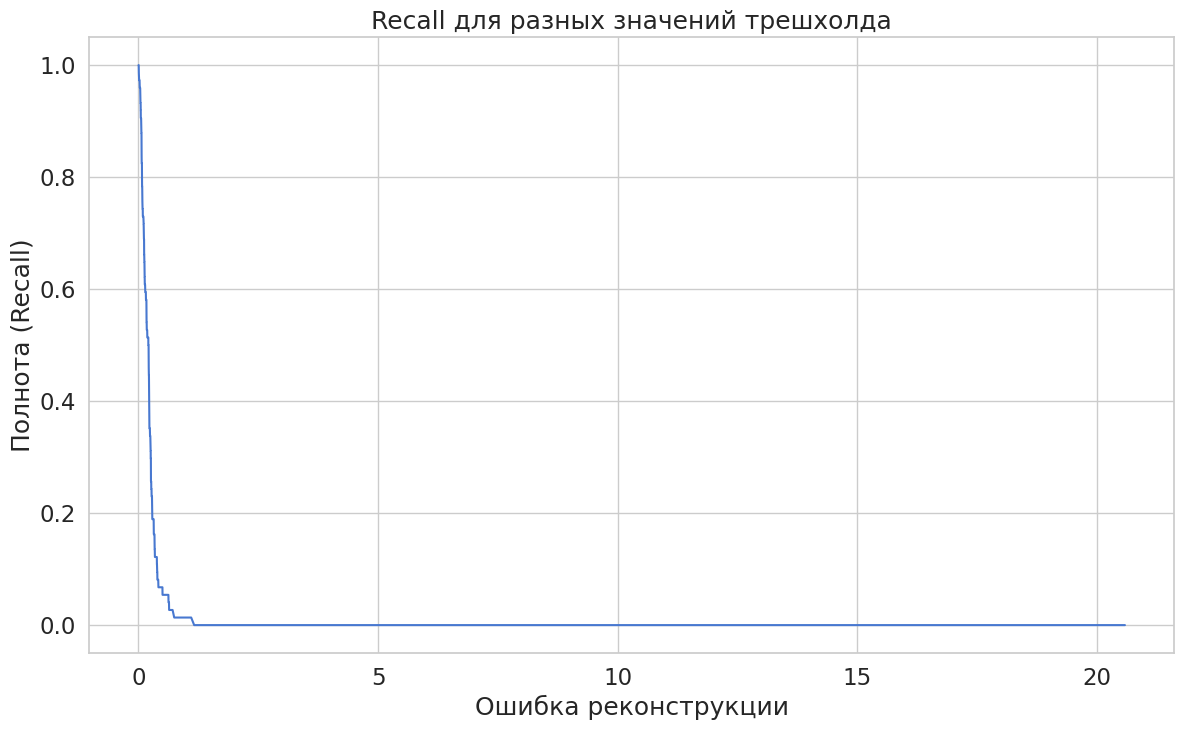

In [37]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall для разных значений трешхолда')
plt.xlabel('Ошибка реконструкции')
plt.ylabel('Полнота (Recall)')
plt.show()

Здесь мы имеем прямо противоположную ситуацию. По мере увеличения ошибки реконструкции recall (полнота) уменьшается.

## Используем модель для того, чтобы сделать предсказание

Чтобы предсказать, является ли новая/невидимая транзакция нормальной или мошеннической, мы рассчитаем ошибку реконструкции на основе самих данных транзакции. Если ошибка превышает предопределенный порог, мы помечаем ее как мошенничество (поскольку наша модель должна иметь низкую ошибку при обычных транзакциях). Давайте выберем это значение:

In [38]:
threshold = 2.9

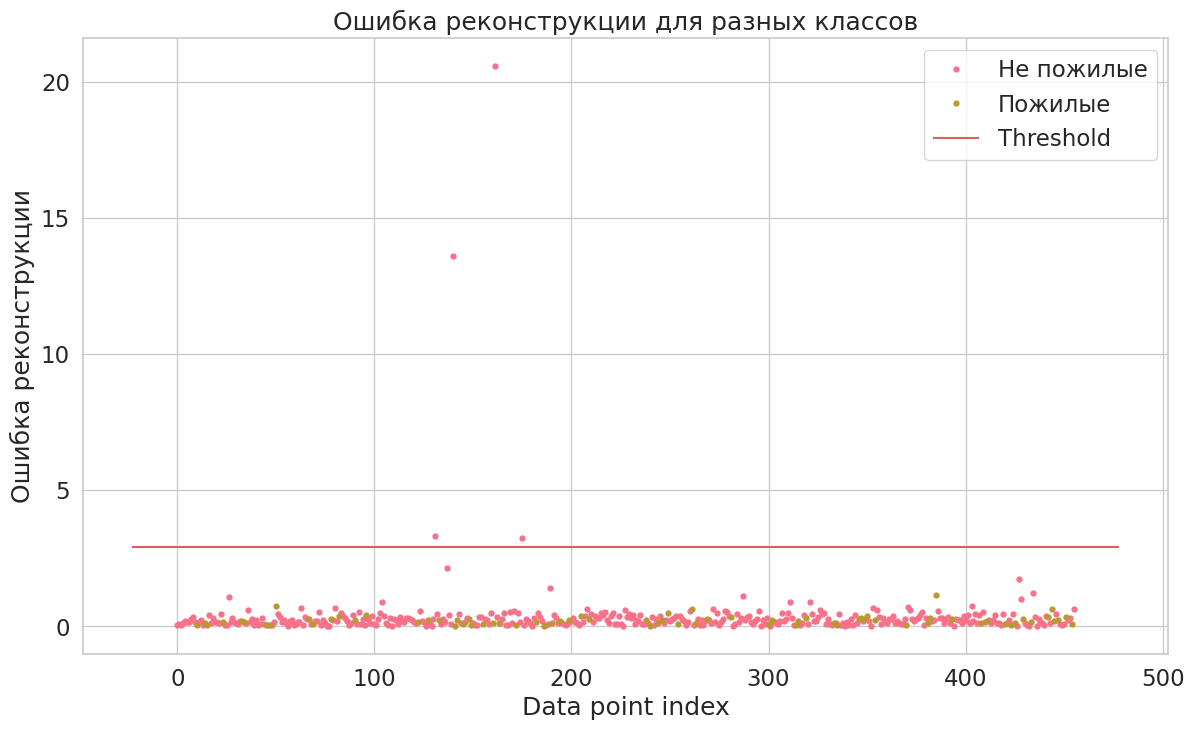

In [39]:
groups = reconstructionErrorDF.groupby('age_group')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.pred_loss, marker='o', ms=3.5, linestyle='',
            label= "Пожилые" if name == 1 else "Не пожилые")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Ошибка реконструкции для разных классов")
plt.ylabel("Ошибка реконструкции")
plt.xlabel("Data point index")
plt.show();

Построим и посмотрим confusion matrix:

<ipython-input-40-cce426e0077b>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Pastel2'));


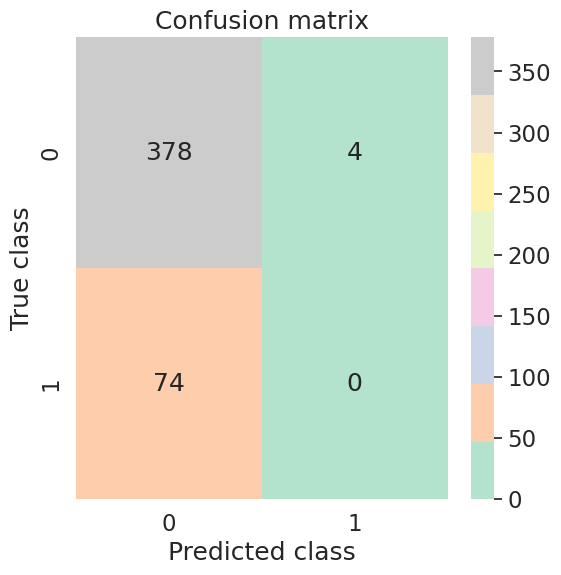

In [40]:
y_pred = [1 if e > threshold else 0 for e in reconstructionErrorDF.pred_loss.values]
conf_matrix = confusion_matrix(reconstructionErrorDF.age_group, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d",
            cmap=plt.cm.get_cmap('Pastel2'));
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

Довольно много ошибается

# Посмотрим с балансом:

In [41]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Создаем новый сбалансированный DataFrame
balanced_df = pd.DataFrame(X_resampled, columns=X.columns)
balanced_df['age_group'] = y_resampled

# Проверяем сбалансированность классов
print(balanced_df['age_group'].value_counts())

age_group
0    1914
1    1914
Name: count, dtype: int64


In [42]:
X_train, X_test = train_test_split(balanced_df, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.age_group == 0]
X_train = X_train.drop(['age_group'], axis=1)
y_test = X_test['age_group']
X_test = X_test.drop(['age_group'], axis=1)

X_train = X_train.values
X_test = X_test.values
y_test = y_test.values

print(y_test.size)

766


In [43]:
class Autoencoder(nn.Module):
    def __init__(self):  # Исправлено на __init__
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(7, 4),  # Изменено на 7 на входе
            nn.Tanh(),
            nn.Linear(4, 3),  # Уменьшаем размерность до 3
            nn.LeakyReLU(),
        )

        self.decoder = nn.Sequential(
            nn.Linear(3, 4),  # Увеличиваем до 4
            nn.Tanh(),
            nn.Linear(4, 7),  # Возвращаем на 7
            nn.LeakyReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Инициализация модели
model = Autoencoder().double()

# Параметры обучения
num_epochs = 100
minibatch_size = 32
learning_rate = 1e-3

# Создание загрузчиков данных
train_loader = data_utils.DataLoader(X_train, batch_size=minibatch_size, shuffle=True)  # Преобразование в double
test_loader = data_utils.DataLoader(X_test, batch_size=1, shuffle=False)  # Преобразование в double

# Определение функции потерь и оптимизатора
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=10e-05)

# Словарь для хранения истории потерь
history = {}
history['train_loss'] = []
history['test_loss'] = []

# Цикл обучения
for epoch in range(num_epochs):
    h = np.array([])
    for data in train_loader:
        # ===================forward=====================
        output = model(data)
        loss = criterion(output, data)
        h = np.append(h, loss.item())

        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # ===================log========================
    mean_loss = np.mean(h)
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, num_epochs, mean_loss))
    history['train_loss'].append(mean_loss)

# Сохранение модели
torch.save(model.state_dict(), './credit_card_model.pth')

epoch [1/100], loss:3596.1738
epoch [2/100], loss:3588.5682
epoch [3/100], loss:3555.3705
epoch [4/100], loss:3550.2808
epoch [5/100], loss:3493.2465
epoch [6/100], loss:3467.4523
epoch [7/100], loss:3452.3860
epoch [8/100], loss:3425.3431
epoch [9/100], loss:3409.1912
epoch [10/100], loss:3394.9757
epoch [11/100], loss:3371.5050
epoch [12/100], loss:3370.3296
epoch [13/100], loss:3345.1209
epoch [14/100], loss:3320.6337
epoch [15/100], loss:3310.3913
epoch [16/100], loss:3292.2907
epoch [17/100], loss:3281.1798
epoch [18/100], loss:3259.4831
epoch [19/100], loss:3242.4385
epoch [20/100], loss:3249.7346
epoch [21/100], loss:3212.2667
epoch [22/100], loss:3189.0252
epoch [23/100], loss:3175.7706
epoch [24/100], loss:3156.2830
epoch [25/100], loss:3147.8056
epoch [26/100], loss:3130.7535
epoch [27/100], loss:3165.2012
epoch [28/100], loss:3100.1584
epoch [29/100], loss:3084.1982
epoch [30/100], loss:3071.3705
epoch [31/100], loss:3082.0466
epoch [32/100], loss:3049.6052
epoch [33/100], l

In [44]:
pred_losses = {'pred_loss' : []}
model.eval()
with torch.no_grad():
    for data in test_loader:
        inputs = data
        outputs = model(inputs)
        loss = criterion(outputs, inputs).data.item()
        pred_losses['pred_loss'].append(loss)
reconstructionErrorDF = pd.DataFrame(pred_losses)
reconstructionErrorDF['age_group'] = y_test

<ipython-input-45-cce426e0077b>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Pastel2'));


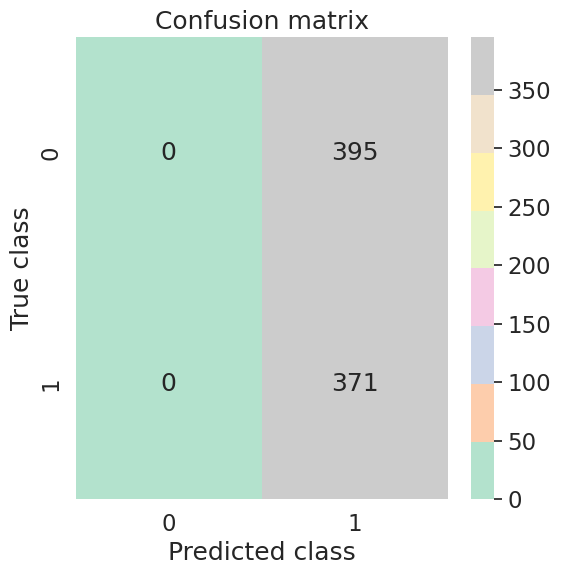

In [45]:
y_pred = [1 if e > threshold else 0 for e in reconstructionErrorDF.pred_loss.values]
conf_matrix = confusion_matrix(reconstructionErrorDF.age_group, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d",
            cmap=plt.cm.get_cmap('Pastel2'));
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()